<a href="https://colab.research.google.com/github/DarioMameli/DL_Assignments/blob/main/DL_Assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

Firstly let's install and upgrade the necessary packages

In [ ]:
!pip install keras --upgrade --quiet
!pip install keras-tuner --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 15.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.0.5 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 4.1 MB/s eta 0:00:00


Let's import all the necessary functions and packages

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import keras
from keras import regularizers
import matplotlib.gridspec as gridspec
from keras.datasets import fashion_mnist
from keras.layers import Dense, Flatten
from keras.models import Sequential
from keras.utils import to_categorical
import keras_tuner as kt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from dl_utils import plot_history

from sklearn.metrics import confusion_matrix, classification_report

Check the versions of the packages

In [ ]:
print(tf.__version__)
print(keras.__version__)

2.15.0
3.0.5


Check the runtime device

In [ ]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

# Load data

Load the training and test set and display its shape

In [ ]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
print(X_train.shape)

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
(60000, 28, 28)


Show the first instance and corresponding label

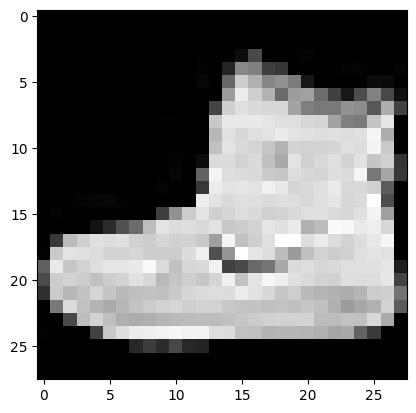

Label = 9


In [ ]:
# Show an instance
plt.imshow(X_train[0], cmap="gray")
plt.show()

# Print label
print("Label =", y_train[0])


Preprocess the feature vectors

In [ ]:
# Input data preprocessing
print(np.min(X_train), np.max(X_train))
X_train = X_train.astype("float32")
X_test = X_test.astype("float32")

X_train /= 255
X_test /= 255

print(X_train.shape[0], "train samples")
print(X_test.shape[0], "test samples")

0 255
60000 train samples
10000 test samples


Preprocess the labels

In [ ]:
# Labels preprocessing
min = np.min(y_train)
max = np.max(y_train)
print(min, max)
num_classes = max + 1

y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

print("First label is now = ", y_train[0])

0 9
First label is now =  [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


# Build the models


## Baseline model
Here we implement the MLP seen in the lab: we use a simple fully connected network here using 8 hidden neurons, followed by another layer of 8 hidden neurons, and finally our output layer. We use the ReLU activation function, except for the output, where we apply a softmax activation as we're doing a multiclass classification here.

This model represents the baseline that we want to improve.

In [ ]:
def MLPModel(num_classes):
    model = Sequential()
    model.add(Flatten(input_shape=(28, 28)))
    model.add(Dense(8, activation="relu"))
    model.add(Dense(8, activation="relu"))
    model.add(Dense(num_classes, activation="softmax"))
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"])
    return model

In [ ]:
model = MLPModel(num_classes)
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 8)                   │           6,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8)                   │              72 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │              90 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,442 (25.16 KB)

 Trainable params: 6,442 (25.16 KB)

 Non-trainable params: 0 (0.00 B)

## Our model

Here we implement our version of the MLP by creating wrapper class for the HyperModel of the Keras Tuner class, in order to perform our custom search via Hyperband algorithm of the best hyperparameters of our model. The hyperparameters we tune are the number of neurons in the two hidden layers, the activation function, the learning rate, the batch size. We perform data augmentation in the fit function to allow the model to deal with different image transformations. We split the training data into a training and validation set to improve the generalization.

In [ ]:
class MyMLPModel(kt.HyperModel):
  # build function to override
  def build(self, hp):
        model = self.build_MLP(hp)
        return model

  # Sets up the hyperparameters and calls the actual building model function
  def build_MLP(self, hp):
      # Tune the number of units for the Dense layers
      hp_units1 = hp.Int('unitsL1', min_value=32, max_value=512, step=32)
      hp_units2 = hp.Int('unitsL2', min_value=32, max_value=512, step=32)

      # Choose the activation function for the Dense layers
      hp_activation = hp.Choice("activation", ["relu", "tanh"])

      # Tune the learning rate for the optimizer
      hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

      # call existing model-building code with the hyperparameter values.
      model = self.build_MLP_hp(
          hp_units1=hp_units1, hp_units2=hp_units2, hp_activation=hp_activation,
          hp_learning_rate=hp_learning_rate
      )
      return model

  # Builds the model given the parameters
  def build_MLP_hp(self, hp_units1, hp_units2, hp_activation, hp_learning_rate):
      model = Sequential()
      model.add(Flatten(input_shape=(28, 28)))
      model.add(Dense(units=hp_units1, activation=hp_activation))
      model.add(Dense(units=hp_units2, activation=hp_activation))
      model.add(Dense(10, activation="softmax"))
      model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                    loss="categorical_crossentropy", metrics=["accuracy"])
      return model

  # fit function to override
  def fit(self, hp, model, *args, **kwargs):
        # Initialize ImageDataGenerator for data augmentation specifying a bunch of different transformations
        datagen = ImageDataGenerator(
            rotation_range=10,
            width_shift_range=0.1,
            height_shift_range=0.1,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            vertical_flip = True,
            fill_mode='nearest',
            validation_split=0.2
        )
        # Retrieve the training data
        X_train = args[0]
        # Increase the dimensionality of the data for datagen
        X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
        # Fit the data generator on the training data
        datagen.fit(X_train)
        # Tune the batch size
        hp_batch_size = hp.Choice('batch_size', values=[16, 32, 64, 128, 256])
        # Use the generator to augment the data during training
        return model.fit(
        datagen.flow(X_train, y_train, batch_size=hp_batch_size, shuffle=True, subset='training'), # Use augmentation on the training set
        validation_data=datagen.flow(X_train, y_train, subset='validation'),  # Use augmentation on the validation set
        )

The hyperband tuner object allows to perform the search of the hyperparameters using hyperband algorithm.

In [ ]:
# Define the hyperband tuner object, passing the model where to perform the search
tuner = kt.Hyperband(MyMLPModel(),
                     objective='val_accuracy',
                     max_epochs=10,
                     #overwrite = True,
                     max_consecutive_failed_trials=5,
                     project_name='my_mlp_tuning',
                     directory='my_mlp_tuning',
)
# Summarize the search space
tuner.search_space_summary()

Search space summary
Default search space size: 3
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


# Training


## Baseline's training

Here we train the baseline model using the same parameters specified in the lab.

Epoch 1/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.2854 - loss: 1.7425 - val_accuracy: 0.6852 - val_loss: 0.8734
Epoch 2/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7131 - loss: 0.8036 - val_accuracy: 0.7847 - val_loss: 0.6436
Epoch 3/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.7932 - loss: 0.6224 - val_accuracy: 0.8076 - val_loss: 0.5672
Epoch 4/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8136 - loss: 0.5577 - val_accuracy: 0.8164 - val_loss: 0.5362
Epoch 5/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8220 - loss: 0.5250 - val_accuracy: 0.8250 - val_loss: 0.5192


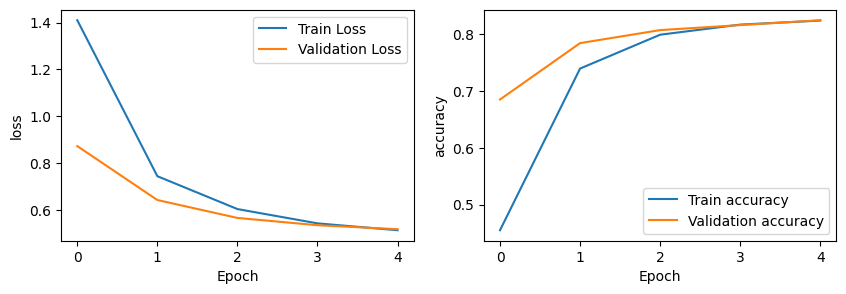

In [ ]:
batch_size = 128
epochs = 5

# Fit the model
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_split=0.2)
plot_history(history)

## Training the best model

Here we first perform the search of the best parameters using the hyperband tuner previously defined, then we train the best model with a train-validation split. We specify a high number of epochs because the early stopping function allows to stop the training by monitoring the validation loss, to prevent overfitting.

Trial 28 Complete [00h 00m 26s]
val_accuracy: 0.6836666464805603

Best val_accuracy So Far: 0.7277500033378601
Total elapsed time: 00h 14m 53s
Epoch 1/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.7790 - loss: 0.6335 - val_accuracy: 0.8291 - val_loss: 0.4576
Epoch 2/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8566 - loss: 0.3859 - val_accuracy: 0.8478 - val_loss: 0.3911
Epoch 3/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.8759 - loss: 0.3342 - val_accuracy: 0.8662 - val_loss: 0.3591
Epoch 4/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8874 - loss: 0.3094 - val_accuracy: 0.8812 - val_loss: 0.3364
Epoch 5/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.8934 - loss: 0.2885 - val_accuracy: 0.8799 - val_loss: 0.3336
Epoch 6/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.8970 - loss: 0.2719 - val_accuracy: 0.8786 - val_loss: 0.3382
Epoch 7/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.9015 - 

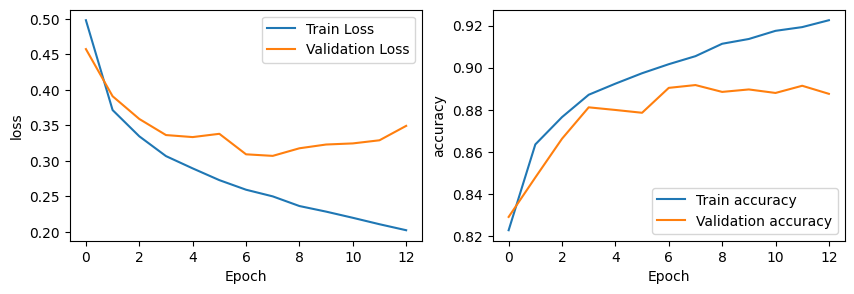

Best epoch: 8


In [ ]:
# Early stop to prevent overfitting
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# Perform the search
tuner.search(X_train, y_train, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[stop_early])

plot_history(history)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

# Evaluation

## Baseline evaluation

Print the scores of the trained baseline model.

In [ ]:
base_score = model.evaluate(X_test, y_test, verbose=0)

print("Baseline model")
print("Test loss:", base_score[0])
print("Test accuracy:", base_score[1])

Baseline model
Test loss: 0.5460600256919861
Test accuracy: 0.815500020980835


## Best model evaluation

Print the scores of the best model.
Print the increment in the test set's accuracy.

In [ ]:
best_score = best_model.evaluate(X_test, y_test, verbose=0)

print("Best model")
print("Best parameters:", best_hps.values)
print("Test loss:", best_score[0])
print("Test accuracy:", best_score[1])
print("Test accuracy improvement:", 100*(best_score[1]-base_score[1])/base_score[1])

Keras Tuner model
Best parameters: {'units': 192, 'activation': 'relu', 'learning_rate': 0.001, 'batch_size': 32, 'tuner/epochs': 2, 'tuner/initial_epoch': 0, 'tuner/bracket': 2, 'tuner/round': 0}
Test loss: 0.3889254629611969
Test accuracy: 0.8791000247001648


## Best and worst predictions

Here we plot the 5 best and 5 worst predictions and make some hypotheses on the reasons.

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 898us/step


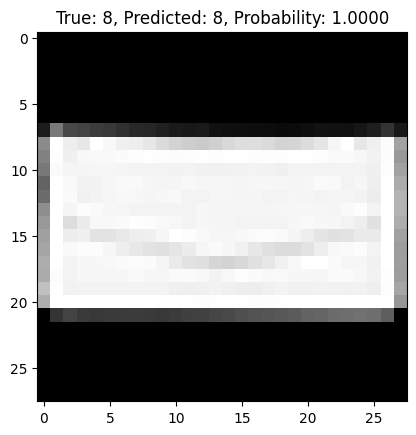

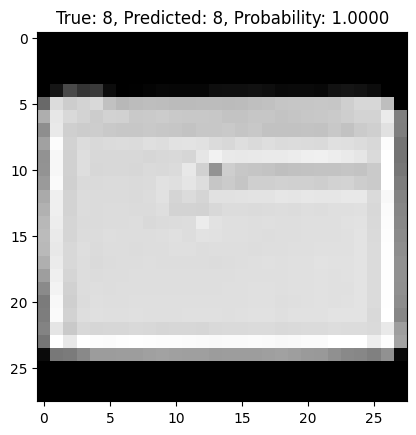

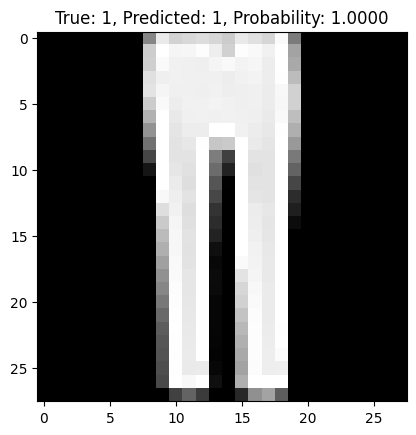

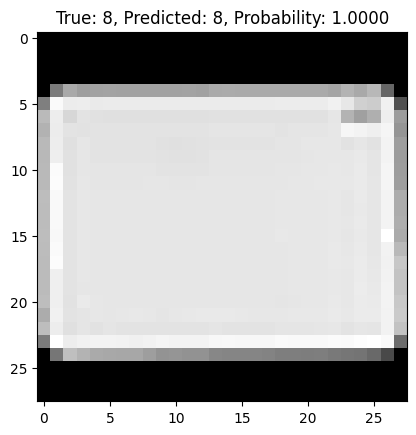

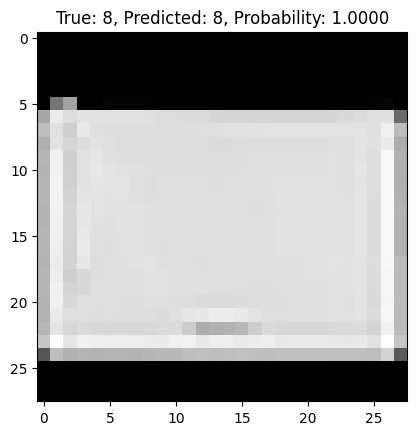

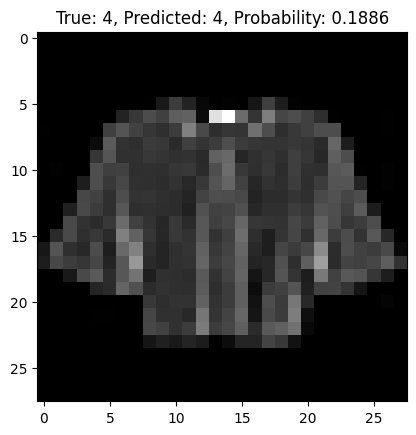

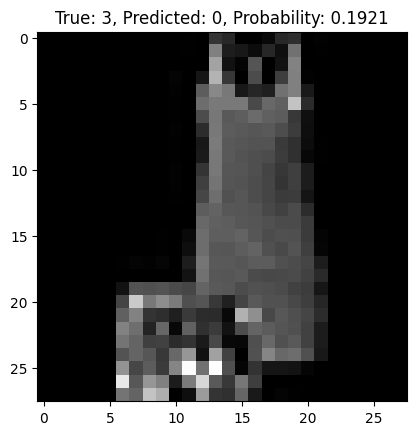

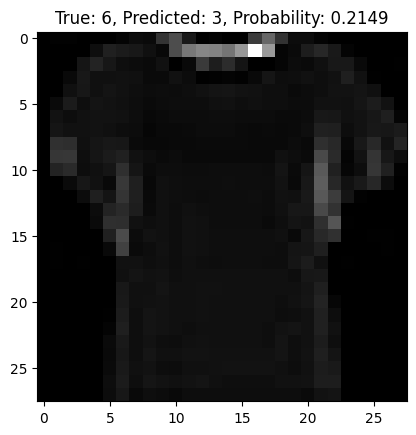

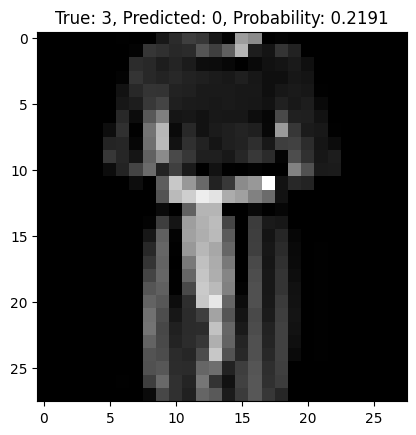

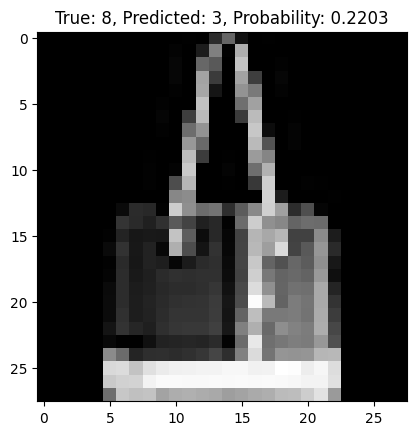

              precision    recall  f1-score   support

           0       0.76      0.82      0.79      6000
           1       0.98      0.94      0.96      6000
           2       0.72      0.76      0.74      6000
           3       0.82      0.85      0.84      6000
           4       0.65      0.85      0.73      6000
           5       0.93      0.90      0.92      6000
           6       0.66      0.38      0.48      6000
           7       0.89      0.93      0.91      6000
           8       0.96      0.93      0.94      6000
           9       0.93      0.92      0.93      6000

    accuracy                           0.83     60000
   macro avg       0.83      0.83      0.82     60000
weighted avg       0.83      0.83      0.82     60000



In [ ]:
y_pred_probs = model.predict(X_train)

y_max_probs = list(range(len(y_pred_probs)))

y_pred_labels = np.argmax(y_pred_probs, axis=1)

y_true_labels = np.argmax(y_train, axis=1)

for i, row in enumerate(y_pred_probs):
  y_max_probs[i] = np.max(row)

indices = np.argsort(y_max_probs)

most_convinced_indices = indices[-5:]
most_confused_indices = indices[:5]

for index in most_convinced_indices:
    plt.imshow(X_train[index],cmap="gray")
    plt.title(f'True: {y_true_labels[index]}, Predicted: {y_pred_labels[index]}, Probability: {y_pred_probs[index, y_pred_labels[index]]:.4f}')
    plt.show()

for index in most_confused_indices:
    plt.imshow(X_train[index],cmap="gray")
    plt.title(f'True: {y_true_labels[index]}, Predicted: {y_pred_labels[index]}, Probability: {y_pred_probs[index, y_pred_labels[index]]:.4f}')
    plt.show()

print(classification_report(y_true_labels, y_pred_labels))


The model exhibits weaknesses in accurately predicting clothing items like coats or dresses, while demonstrating strengths in classifying bags trousers and shoes. There is an opportunity for improvement by focusing on enhancing the model's performance in the classification of clothing items.

Now we are going to retrain the model with this clases

In [30]:
worst_clases = [0, 2, 3, 4, 6]
y_true_labels = np.argmax(y_train, axis=1)
mask = np.isin(y_true_labels, worst_clases)
X_retrain = X_train[mask]
y_retrain = y_train[mask]


Epoch 1/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.8299 - loss: 0.4771 - val_accuracy: 0.8235 - val_loss: 0.4871
Epoch 2/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - accuracy: 0.8784 - loss: 0.3145 - val_accuracy: 0.8260 - val_loss: 0.5082
Epoch 3/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.8789 - loss: 0.3066 - val_accuracy: 0.8275 - val_loss: 0.5098
Epoch 4/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.8899 - loss: 0.2853 - val_accuracy: 0.8275 - val_loss: 0.5122
Epoch 5/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.8942 - loss: 0.2654 - val_accuracy: 0.8240 - val_loss: 0.5490


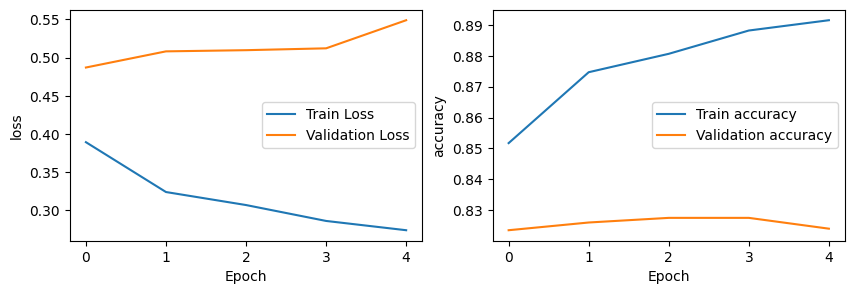

Best epoch: 3


In [31]:

history = best_model.fit(X_retrain, y_retrain, epochs=50, validation_split=0.2, callbacks=[stop_early])

plot_history(history)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

In [32]:
best_score1 = best_model.evaluate(X_test, y_test, verbose=0)

print("Best model")
print("Best parameters:", best_hps.values)
print("Test loss:", best_score1[0])
print("Test accuracy:", best_score1[1])
print("Test accuracy improvement:", 100*(best_score1[1]-best_score[1])/best_score[1])

Best model
Best parameters: {'units': 416, 'activation': 'relu', 'learning_rate': 0.001, 'batch_size': 64, 'tuner/epochs': 2, 'tuner/initial_epoch': 0, 'tuner/bracket': 2, 'tuner/round': 0}
Test loss: 0.7607358694076538
Test accuracy: 0.8291000127792358
Test accuracy improvement: 29.769922706142374
